In [19]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import optim
# import the model
from mnist_model import Conv2d_model

In [20]:
# Normalization function for the images from [0, 255] to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
                              ])

In [21]:
batch_size = 64
# Download the training and testing MNIST dataset
trainset = datasets.MNIST('training-data', download=True, train=True, transform = transform)
valset = datasets.MNIST('training-data', download=True, train=False, transform = transform)

# Partitioning the dataset into batches for training and testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [22]:
# iterator to iterate through our training data set
dataiter = iter(trainloader)
images, labels = dataiter.next()

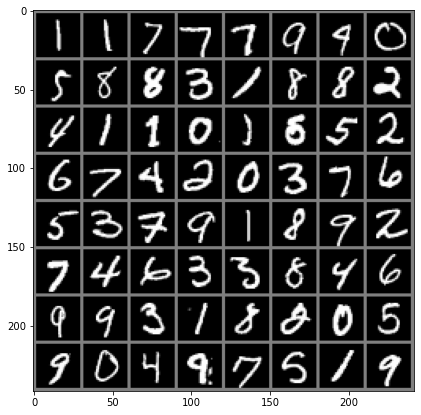

In [23]:
# Simple grid to have a glance at the training dataset
plt.figure(figsize=(7,7))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [24]:
# model
model = Conv2d_model()
print(model)

Conv2d_model(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 24, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(24, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=200, bias=False)
  (bn4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dr): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=10, bias=False)
)


In [25]:
# Checking model performance with the testing dataset
def test():
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valloader:
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss += F.nll_loss(output, target, reduction='sum').item()
    test_loss /= len(valloader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valloader.dataset),
        100. * correct / len(valloader.dataset)))

In [26]:
#### optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# cross-entropy loss for the model train (using negative log-likelihood loss)
criterion = nn.NLLLoss()

# Training the model
def train(epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

for epoch in range(10):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.400979


KeyboardInterrupt: 

In [ ]:
# Save the trained model
torch.save(model.state_dict(), './models/conv2d_model.pt')

predicted digit =  1


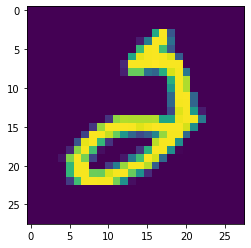

In [10]:
model = torch.load('./models/conv2d_model.pt')
model.eval()
# An image prediction, output a class probability
images , labels = next(iter(valloader))
with torch.no_grad():
    logps = model(images)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("predicted digit = ", probab.index(max(probab)))
plt.imshow(images[0][0])